<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/Developing-Tool/Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEDIA BIAS Thesis

# Setting up Environment

### PIP install

In [50]:
!pip3 install requests-html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [51]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium

# Install xvfb
apt install -y xvfb

# Install Selenium-Profiles
pip uninstall -y selenium_profiles
pip install --no-cache-dir selenium_profiles>=2.2.6

# pip install https://github.com/kaliiiiiiiiii/Selenium-Profiles/archive/refs/heads/dev.zip # dev-branch

# install python packages
pip install google-colab-shell
pip install webdriver-manager
pip install Pyvirtualdisplay 

Executing: /tmp/apt-key-gpghome.i5skgd78aA/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.vOYJ30zScq/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.GQWiNyonI6/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

In [52]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date
from requests_html import HTMLSession 

### Mounting to GDrive

In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### dir variable

In [54]:
dir  = "/content/gdrive/MyDrive/THESIS-MS/Git-Thesis22-23/"

# Scraping

1. GMA7
2. ABS CBN (Online)
3. CNN Philippines 
4. Philippine Star 
5. Rappler
6. Manila Bulletin - 
  (infinite more)
7. TV5
8. Manila Standard
9. Sunstar Philippines

## Extract Source Function

In [55]:
def extract_source(url):
    agent = {"User-Agent":"Chrome/105.0.0.0"}
    try:
      source=requests.get(url, headers=agent)
    except Exception as e:                                   # this describes what to do if an exception is thrown
      error_type, error_obj, error_info = sys.exc_info()      # get the exception information
      print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
      print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
    
    return source                                               #ignore this page. Abandon this and go back.

## Chrome driver

In [113]:
# https://colab.research.google.com/github/kaliiiiiiiiii/Selenium-Profiles/blob/master/google-colab/selenium_profiles.ipynb#scrollTo=lThF-0LvpZf3
## @title Start actual driver
from selenium_profiles.webdriver import Chrome
from selenium_profiles.profiles import profiles
from selenium.webdriver.common.by import By  # locate elements
from selenium_profiles.utils.colab_utils import display, showscreen, show_html # virtual display
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementNotVisibleException, ElementNotSelectableException
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
# options.add_argument('--disable-blink-features=AutomationControlled')

chromedriver_path = ChromeDriverManager(version="90.0.4430.24").install()

profile = profiles.Windows() # or .Android
profile["cdp"]["cores"] = None # Chrome 90 doesn't allow emulating cores :(driver = mydriver.start(profile, uc_driver=False, executable_path=chromedriver_path)

mydriver = Chrome(profile, executable_path=chromedriver_path, options=options)

display = display()

display.start_display()
driver = mydriver.start()

## Manila Bulletin

https://www.scrapingbee.com/webscraping-questions/selenium/how-to-scroll-to-element-selenium/#:~:text=You%20can%20scroll%20to%20an,the%20execute_script%20as%20an%20argument.

https://mb.com.ph/category/national
clicked


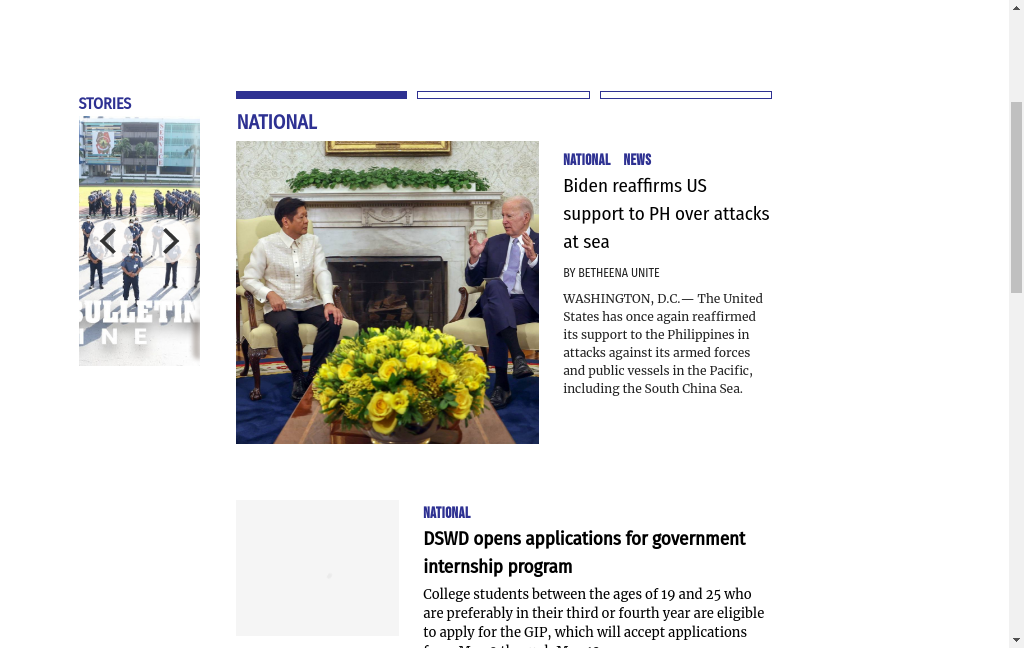

clicked


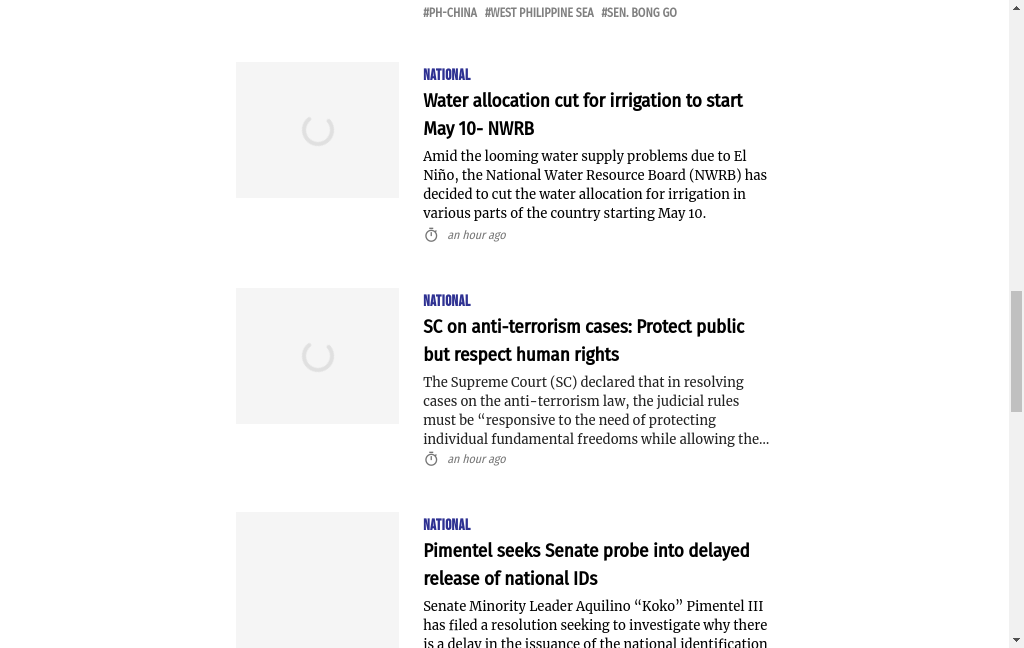

clicked


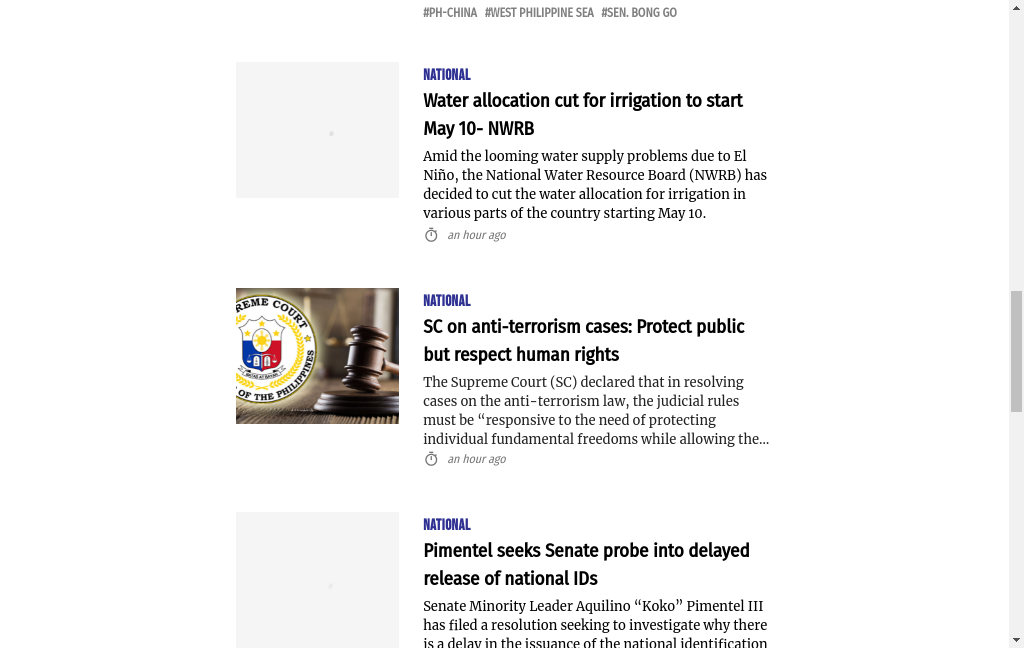

0


In [114]:
## Manila bulletin
# News link getter for National News

site = "manilaBulletin"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://mb.com.ph/category/national'
print(url)

for x in range(3):
  try:
    driver.get(url)
    driver.implicitly_wait(10)

    js_code = "arguments[0].scrollIntoView();"
  
    # The WebElement you want to scroll to
    element2 = driver.find_element(By.XPATH, '//*[@id="app"]/div/main/div/div/div/div[3]/div[2]/div[2]/div/div[2]/button')

    # Execute the JS script
    driver.execute_script(js_code, element2)


    wait = WebDriverWait(driver, timeout=20, poll_frequency=1, ignored_exceptions=[ElementNotSelectableException])
    # element = wait.until(EC.visibility_of_element_located((By.XPATH, "more-btn mb-font-more-button v-btn v-btn--text theme--light v-size--default indigo--text")))
    # moreButton = driver.find_element(By.CLASS_NAME, "text-center").find_element(By.CLASS_NAME, "more-btn mb-font-more-button v-btn v-btn--text theme--light v-size--default indigo--text")
    element2.click()
    print('clicked')
    showscreen(driver)
    #  //*[@id="app"]/div/main/div/div/div/div[3]/div[2]/div[2]/div/div[2]/button
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)  


soup=BeautifulSoup(extract_source(url).text, 'html.parser')
links=soup.find("div", {'class' : 'article-list mx-auto'}).find_all('div',attrs={'class':'row mb-5'})
print(len(links))

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

for j in links:
    Statement = j.find('h4', {'class' : 'mb-font-article-title mt-0 mb-1'}).find('a').text.strip()
    Link = "https://mb.com.ph"+j.find("h4", {'class' : 'mb-font-article-title mt-0 mb-1'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'ml-2'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)
    
data.to_csv(filename)
data.head()

driver.quit()
display.stop_display()

In [115]:
data.head()

,Statement,Link,Date


In [81]:
print(soup.prettify())

<!DOCTYPE html>
<html data-n-head="%7B%22lang%22:%7B%22ssr%22:%22en%22%7D%7D" data-n-head-ssr="" lang="en">
 <head>
  <title>
   National - Manila Bulletin
  </title>
  <meta charset="utf-8" data-n-head="ssr"/>
  <meta content="width=device-width, initial-scale=1" data-n-head="ssr" name="viewport"/>
  <meta content="" data-hid="description" data-n-head="ssr" name="description"/>
  <meta content="telephone=no" data-n-head="ssr" name="format-detection"/>
  <link data-n-head="ssr" href="/favicon.png" rel="icon" type="image/x-icon"/>
  <link data-n-head="ssr" href="https://cdn.jsdelivr.net/npm/@mdi/font@latest/css/materialdesignicons.min.css" rel="stylesheet" type="text/css"/>
  <style data-n-head="vuetify" id="vuetify-theme-stylesheet" nonce="undefined" type="text/css">
   .v-application a { color: #1976d2; }
.v-application .primary {
  background-color: #1976d2 !important;
  border-color: #1976d2 !important;
}
.v-application .primary--text {
  color: #1976d2 !important;
  caret-color: #1

In [ ]:
# Article Reader from LINK
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  print(url)

  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')

  text=soup.find("div", {'class' : 'col-md-8 col-xl-8 col-12'})
  # print(content.prettify())
  # textList =soup.find("div", {'class' : 'the-article-content'}).find("section", {'class': 'article-content'}).find_all("p")
  
  
  row=[]
  try:
    Title = text.find('h1',{'class':'pt-3 mb-font-article-title'}).text.strip()
    Author = text.find('div',attrs={'class':'mb-font-author-name overflow-nowrap'}).find('a').text.strip()
    Date = text.find('div', attrs={'class': 'pt-0'}).text[:-8]
  except Exception as e:
      pass
  
  body = ""
  textList =  soup.find('div', {'class':'pt-8 custom-article-body mb-font-article-body'}).find_all('p')
  for t in textList:
    body += (t.text.replace('\u200b', '')) +"\n" 

  row.extend((Title, Author, Date, body))
  

  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

## ABS CBN

In [ ]:
## ABS CBN
pagesToGet= 2
topic = "Queen Elizabeth Death"
site = "ABS-CBN_NEWS"


data=pd.DataFrame(columns=['Title','Link','Date',"Topic"])

for page in range(1,pagesToGet+1):
  url = 'https://news.abs-cbn.com/special-pages/search?q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)+'#gsc.tab=0&gsc.q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)
  print(url)

  driver.get(url)
  # WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, '___gcse_0'))) 
  source = driver.page_source

  time.sleep(2)   
  soup = BeautifulSoup(source, 'html.parser')
  searches = soup.find_all('div', {'class':'gsc-webResult gsc-result'})
  filename= f"{dir}{site}-{topic}-NEWS-List.csv"     

  for x in searches:
    frame=[]
    Title = x.find('div', class_="gs-title").find("a").text.strip()
    Date = x.find('div', class_="gs-bidi-start-align gs-snippet").text[:12].strip()
    Link = x.find('a', class_="gs-title")['href']
    frame.extend((Title, Link, Date, topic))

    data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)



data.to_csv(filename)
driver.quit()
data





WebDriverException: ignored

In [ ]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if ('multimedia/photo' in url):
    pass
  else:
    print(url)

    time.sleep(1)   
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')
      
    row=[]
    
    Title = soup.find('h1',{'class':'news-title'}).text.strip()
    Author = soup.find('span',attrs={'class':'editor'}).text.strip()
    Date = soup.find('span', attrs={'class': 'date-posted'}).text[:-8].strip() 
    
    textList =soup.find("div", {'class' :'article-content'}).find_all("p")
    body = ""
    for t in textList:
      if (t.text != "RELATED VIDEO:"):
        body += (t.text) +"\n" 

    row.extend((Title, Author, Date, body))
    

    data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

## GMA 

In [ ]:
# https://www.gmanetwork.com/news/#/search;query=queen%20elizabeth%20death;sortBy=_score;isDesc=1

topic = "Queen Elizabeth Death"
site = "GMA-Network"


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-blink-features=AutomationControlled')
userAgent = "Chrome/105.0.0.0"
chrome_options.add_argument(f"user-agent={userAgent}")
driver = webdriver.Chrome('chromedriver',options=chrome_options)

data=pd.DataFrame(columns=['Title','Link','Date',"Topic"])

url = 'https://www.gmanetwork.com/news/#/search;query='+topic.replace(" ", "%20")+';sortBy=_score;isDesc=1'
print(url)

driver.get(url)
WebDriverWait(driver, 50).until(EC.visibility_of_element_located((By.CLASS_NAME, 'clearfix'))) 
source = driver.page_source

time.sleep(2)   
soup = BeautifulSoup(source, 'html.parser')
searches = soup.find_all('div', {'class':'zd-row-text-wrap'})
filename= f"{dir}{site}-{topic}-NEWS-List.csv"     
print(len(searches))

for x in searches:
  frame=[]
  Title = x.find('h4', class_="zd-result-title ng-star-inserted").text.strip()
  Date = x.find('div', class_="zd-result-subTitle ng-star-inserted").text[:-18].strip()
  partialTitle = ' '.join(Title.split()[:8])

  try:
    Link = ""
    to_Click = driver.find_element(By.XPATH, f"//*[contains(text(), '{Title}')]")
    print(to_Click.text)
    to_Click.click()
    driver.switch_to.window(driver.window_handles[1])
    Link = driver.current_url
    driver.close()
    driver.switch_to.window(driver.window_handles[0])
  except Exception as e:
    print("Something wrong. Error:", e.split()[0])

  frame.extend((Title, Link, Date, topic))

  data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)

data.to_csv(filename)
driver.quit()
data.head(10)


In [ ]:
data

In [ ]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if (url == ""):
    continue
  
  print(url)
  time.sleep(2)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]
  
  Title = soup.find('h1',{'class':'story_links'}).text.strip()
  Author = soup.find('div',attrs={'class':'main-byline'}).find('div').find('div').text.strip()
  Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip() 
  
  textList =soup.find("div", {'class' :'story_main'}).find_all("p")
  body = ""
  for t in textList:
    if (t.find('p', class_="ad")):
      pass
    else:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  

  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

# Application

## Scraping Function

In [ ]:
def abs_scrape(url):
  abs_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])

  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]
  
  Title = soup.find('h1',{'class':'news-title'}).text.strip()
  Author = soup.find('span',attrs={'class':'editor'}).text.strip()
  Date = soup.find('span', attrs={'class': 'date-posted'}).text[:-8].strip() 
  
  textList =soup.find("div", {'class' :'article-content'}).find_all("p")
  body = ""
  for t in textList:
    if (t.text != "RELATED VIDEO:"):
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  
  abs_df = abs_df.append(pd.Series(row, index=abs_df.columns[:len(row)]), ignore_index=True)
  
  return abs_df

In [ ]:
def gma_scrape(url):
  gma_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
  
  time.sleep(2)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]

  Title = soup.find('h1',{'class':'story_links'}).text.strip()
  Author = soup.find('div',attrs={'class':'main-byline'})
  if (Author != None):
    Author = Author.find('div').find('div').text.strip() 
  Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip() 

  
  textList =soup.find("div", {'class' :'story_main'}).find_all("p")
  body = ""
  for t in textList:
    if (t.find('p', class_="ad")):
      pass
    else:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  
  gma_df = gma_df.append(pd.Series(row, index=gma_df.columns[:len(row)]), ignore_index=True)

  return gma_df
  


In [ ]:
def cnn_scrape(url):

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  chrome_options.add_argument('--disable-blink-features=AutomationControlled')
  userAgent = "Chrome/105.0.0.0"
  chrome_options.add_argument(f"user-agent={userAgent}")
  driver = webdriver.Chrome('chromedriver',options=chrome_options)

  driver.get(url)
  WebDriverWait(driver, 50).until(EC.visibility_of_element_located((By.CLASS_NAME, 'title'))) 
  source = driver.page_source

  cnn_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
  
  soup=BeautifulSoup(source, 'html.parser')
  # time.sleep(2)   

  # print(soup)
  row=[]
  
  Title = soup.find('h1',{'class':'title'}).text.strip()
  Author = soup.find('div',attrs={'class':'author-byline'}).find('p').find('a').text.strip()
  Date = soup.find('div', attrs={'class': 'dateLine'}).find('p', {'class': 'dateString no-icon'}).text[10:-11].strip() 
  
  textList =soup.find("div", {'class' :'article-maincontent-p cnn-life-body'}).find_all("p")
  body = ""
  for t in textList:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  

  cnn_df = cnn_df.append(pd.Series(row, index=cnn_df.columns[:len(row)]), ignore_index=True)

  return cnn_df

In [ ]:
def clean(df, text, clean_col , sw = [] ):
    """
    Remove blank texts, replaces text with lower case characters,
    remove special characters, remove other special texts like URLs and Twitter handles, 
    remove leading and trailing whitespaces, and remove stopwords.
    """

    # Remove blank texts
    df[clean_col] = df[text].fillna('')     

    # Transform into lowercase
    df[clean_col] = df[clean_col].str.lower()

    # # Remove non-alphanumeric characters
    df[clean_col] = df[clean_col].str.replace(r'(@[A-Za-z0-9_]+)|([^A-Za-z0-9_ \t])|(\w+:\/\/\S+)', '')
    
    # # Lemmatize verbs
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'v') for x in row.split()]))

    # # Lemmatize adjectives
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'a') for x in row.split()]))

    # # Lemmatize nouns
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'n') for x in row.split()]))

    # Remove trailing and leading whitespaces
    df[clean_col] = df[clean_col].str.replace(r'^\s+|\s+$', '')

    # # Remove stopwords 
    df[clean_col] = df[clean_col].apply(lambda row: ' '.join([word for word in row.split() if word not in (stopwords + sw)])) 

    return df

In [ ]:
def senti_Analysis(df, col, colLabel ):
  sia = SentimentIntensityAnalyzer()
  newcol = {'compoundScore' : [sia.polarity_scores(entry) for entry in col]}
  if (colLabel in df.columns):
      df[colLabel] =  newcol['compoundScore']
  else:
    df.insert(df.shape[1], colLabel, newcol['compoundScore'])
  

## Scrape

In [ ]:
df_ = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
df_ = df_.append(abs_scrape("https://news.abs-cbn.com/news/09/29/22/ovp-eyes-coconut-palace-as-permanent-home"), ignore_index=True)
df_ = df_.append(gma_scrape("https://www.gmanetwork.com/news/topstories/nation/846433/sara-duterte-ovp-in-talks-with-gsis-for-possible-acquisition-of-coconut-palace/story/"), ignore_index=True)
df_.head()

### Oct 6

In [ ]:
df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
abscbn = abs_scrape('https://news.abs-cbn.com/news/10/04/22/who-funded-marcos-sg-trip-not-relevant-says-bersamin')
gma = gma_scrape('https://www.gmanetwork.com/news/topstories/nation/846954/palace-marcos-performed-job-as-president-in-singapore/story/?just_in')
cnn = cnn_scrape('https://www.cnnphilippines.com/news/2022/10/4/Marcos-entitled-to-private-time-funding-source-irrelevant.html')

df = df.append(abscbn)
df = df.append(gma)
df = df.append(cnn)


In [ ]:
addedFilter = ['executive', 'president', 'trip', 'marcos', 'bersamin']
visualize((clean(abscbn,"Text", "cleanText",addedFilter )), "cleanText", "ABS-CBN")
visualize((clean(gma,"Text", "cleanText",addedFilter)), "cleanText", "GMA")
visualize((clean(cnn,"Text", "cleanText", addedFilter)), "cleanText", "CNN")

In [ ]:
df_clean= clean(df_, 'Text', 'clean_Textbody')
df_clean= clean(df_, 'Title', 'clean_Title')
df_clean["clean_Body_Title"] = df_clean["clean_Title"].str.cat(df_clean["clean_Textbody"], sep = "\n")
df_clean.head()

In [ ]:
def POS(df, dfCol, colLabel):
  POS = []
  for index, row in df.iterrows():
    # print(type(row[dfCol]), row[dfCol])
    tokenized = sent_tokenize(row[dfCol])
    for i in tokenized:
      
      # Word tokenizers is used to find the words
      # and punctuation in a string
      wordsList = nltk.word_tokenize(i)

      wordsList = [w for w in wordsList if not w in stopwords]
  
      #  Using a Tagger. Which is part-of-speech
      # tagger or POS-tagger.
      tagged = nltk.pos_tag(wordsList)
      POS.append(tagged)
    df.loc[index, colLabel] =  POS
    
 

In [ ]:
# https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/
POS(df_clean, 'clean_Body_Title', "POS")
df_clean


In [ ]:
df_clean.to_csv(f"{dir}textCompare.csv")